## Index

[1. Import Libraries](#1.-Import-libraries)

[2. Get Training data](#2.-Get-Training-data)

[3. Pre-processing Data](#3.-Pre-processing-Data)

[4. t-sne visualisation](#4.-t-sne-visualisation)

[5. Pre-trained model for Transfer Learning](#5.-Pre-trained-model-for-Transfer-Learning)

[6. Create custom model](#6.-Create-custom-model)

[7. Model training](#7.-Model-training)

[8. t-sne visualisation of NN feature vectors](#8.-t-sne-visualisation-of-NN-feature-vectors)

[9. Test Data](#9.-Test-Data)

[10. Class Prediction](#10.-Class-Prediction)

[11. Model Validation](#11.-Model-Validation)

[12. Improvisations](#12.-Improvisations)

***

## 1. Import libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
from PIL import Image, ImageDraw, ImageOps
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

***

## 2. Get Training data

- We create file path for training and test data from the 'autism-image-data'

In [4]:
# Creating file path for our train data and test data
train_dir = "../input/autism-image-data/AutismDataset/train"
test_dir = "../input/autism-image-data/AutismDataset/test"


 - We get the 'Autistic' and 'Non-Autistic' images from train data, shuffle them and use as training images
 - The dataset has 2450 train images, with 1225 images for each 'Autistic' and 'Non-Autistic' category, our dataset is well balanced among the 2 classes
 - We also get the 300 test images from file path

In [5]:
# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("../input/autism-image-data/AutismDataset/train/{}".format(i)):
        train_non_autistic.append(("../input/autism-image-data/AutismDataset/train/{}".format(i)))
    else:
        train_autistic.append(("../input/autism-image-data/AutismDataset/train/{}".format(i)))
        
# Getting test images from test data file path
test_imgs = ["../input/autism-image-data/AutismDataset/test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

114

- Let's see the training data samples

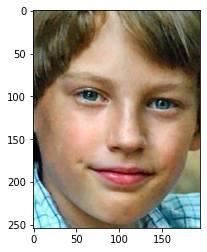

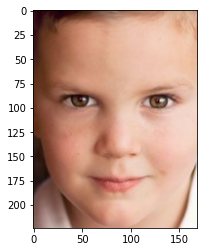

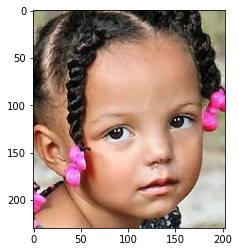

In [6]:
# Plot first 3 images from train_imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

 - As we can see here, the train images are of different dimensions
 - The images need to be resized uniformly before feeding them to our model

***

## 3. Pre-processing Data

 - Let's define the dimensions for resizing the images first
 - Then we write a function to read the images, resize them and specify the labels(y) for each image based on the file name - label '1' if 'Autistic' and label '0' if 'Non-Autistic'
 - X is the resized image and y is the class the image belongs to

In [7]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

- Call the function to read and resize train images, it returns X_train(train images) and y_train(train labels)

In [9]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

- Convert the resized images and labels into numpy array

In [10]:
# Convert the lists to array
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
#sns.countplot(y_train, saturation=1)
#plt.title("Train image labels");

<Figure size 864x576 with 0 Axes>

***

## 4. t-sne visualisation


- t-sne(t-Distributed Stochastic Neighbor Embedding) is an algorithm that is used to visualise data in high dimensional space onto a low dimensional space
- t-sne plots the points which are close in high dimensional space as nearby points in 2 dimensional space as well
- we will be using t-sne here for visualising our data points and later for understanding the neural network's feature maps

In [12]:
# Function for pre-processing images for input to t-sne algorithm
def process_data_tsne(list_of_images):
    
    """ Read and pre-process images to specified dimensions, separate image pixels and labels, convert the lists to numpy array
    
    Parameters:
    list_of_images: Input image data
    
    Returns:
    Numpy array of image pixels and labels
    """
    
    nrows = 150
    ncolumns  = 150
    channels = 3
    
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.COLOR_BGR2GRAY), (nrows, ncolumns)))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    X = np.asarray(X)
    y = np.asarray(y)
    X = X.reshape(2540, 150*150*3)
    
    return X,y

In [13]:
# Pre-process the image data and get the features and labels
features, labels = process_data_tsne(train_imgs)

In [14]:
# Perform t-sne on features
tsne = TSNE(random_state=42).fit_transform(features)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [16]:
# Function for plotting t-sne result as 3D data points
def visualise_tsne_3d(tsne_data, target):
    colour_map = []
    for i in target:
        if i == 1:
            colour_map.append('r')
        else:
            colour_map.append('b')

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne), c=colour_map, s=30, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()


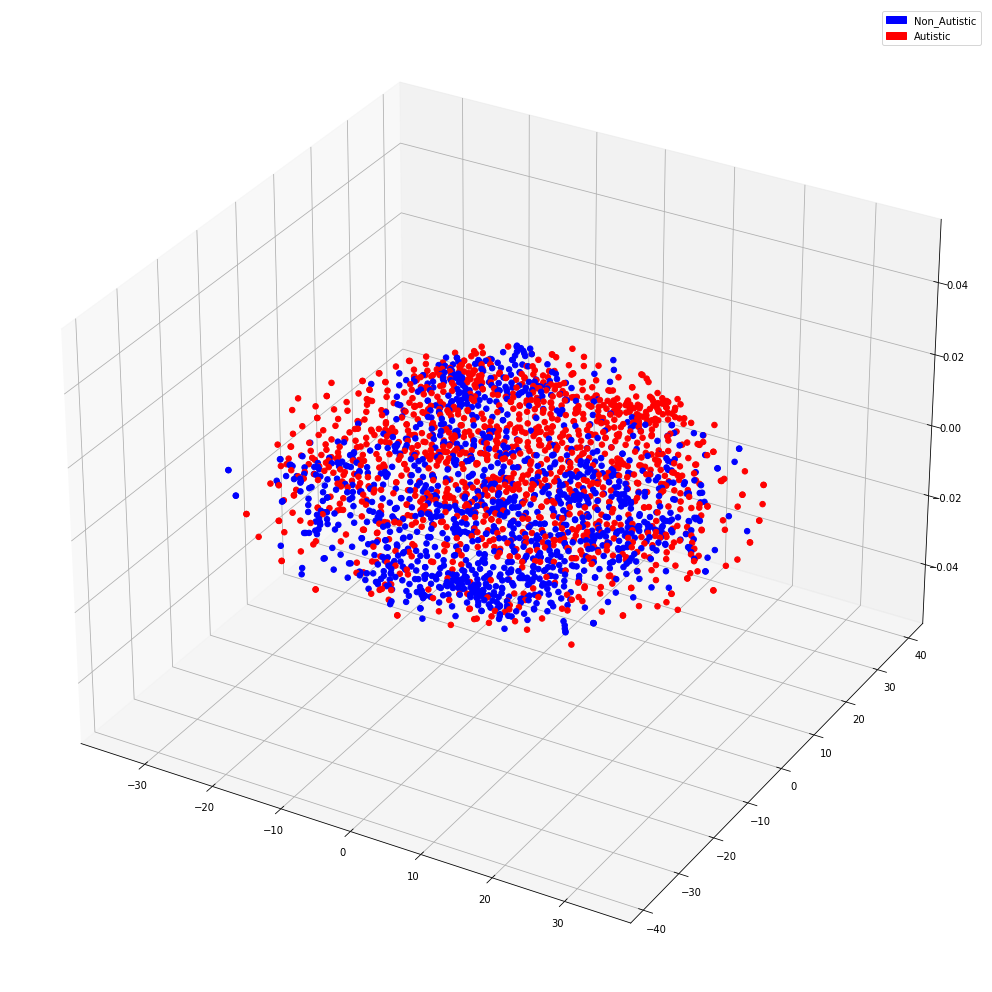

In [17]:
# Visualise t-sne result in 3D
visualise_tsne_3d(tsne, labels)

In [18]:
# Function for plotting t-sne result as data points
def visualise_tsne_datapoints(tsne_data, labels):
    
    """Takes in tsne projections, plots distribution of datapoints in 2 classes"""
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    plt.figure(figsize=(20,18))
    sns.scatterplot(
    x=tx, y=ty,
    hue=labels,
    palette=['blue', 'red'],
    s=300, 
    legend='auto'
    )

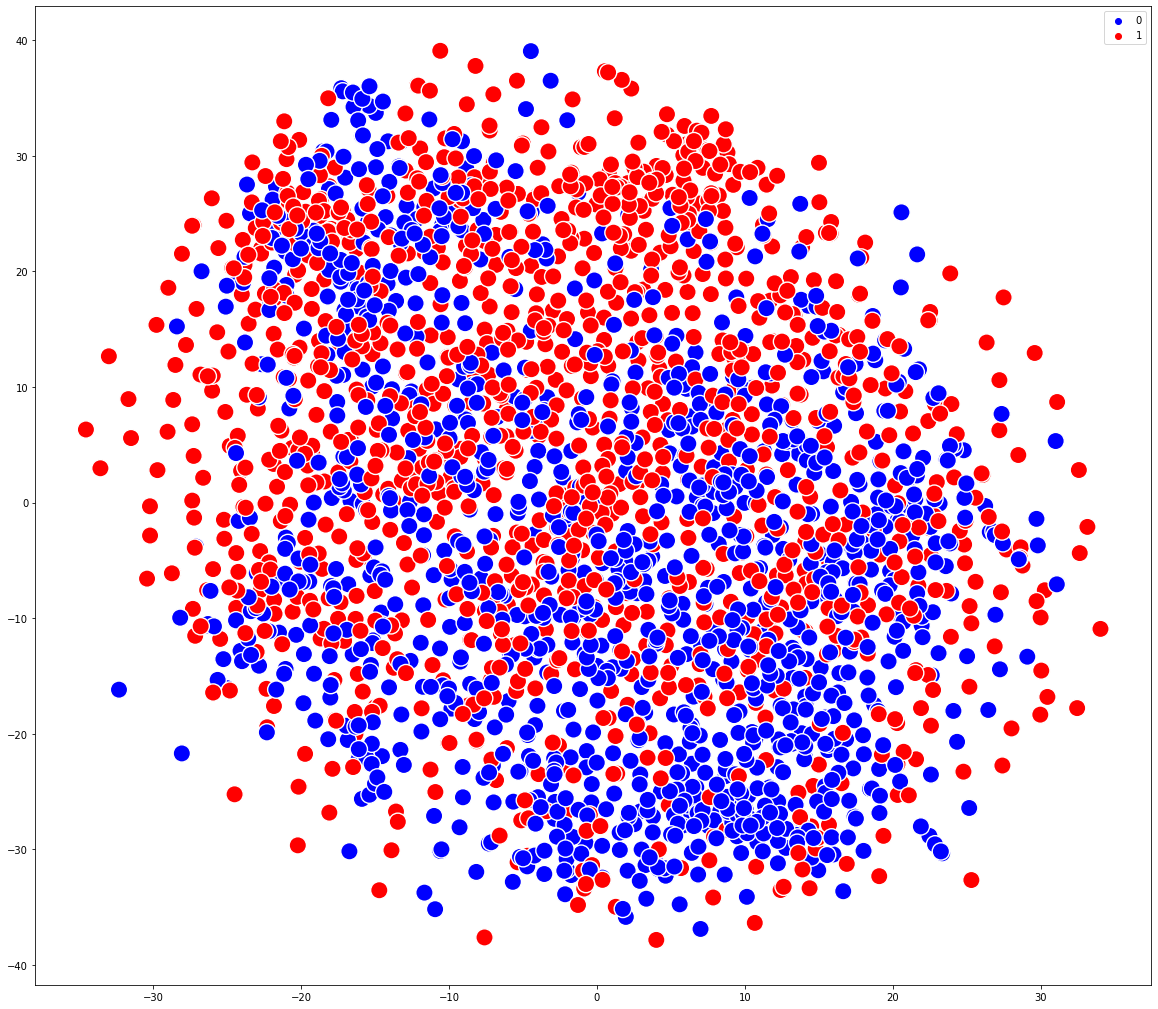

In [19]:
# Visualise class data points in 2 dimensional space
visualise_tsne_datapoints(tsne,labels)

In [20]:
# Function to plot t-sne result as images
def visualise_tsne_images(tsne_data, train_images, labels):
    
    """Takes in tsne projections, plots distribution of images in 2 classes"""
    
    tx = tsne_data[:,0]
    ty = tsne_data[:,1]
    image_paths = [train_images[i] for i in range(len(train_images))]
    #label = y_train

    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 200

    full_image = Image.new('RGBA', (width, height))
    for img, x, y, label in zip(image_paths, tx, ty, labels):
        tile = Image.open(img)
        rs = max(1, tile.width/max_dim, tile.height/max_dim)
        tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
        tile_height, tile_width = tile.size
        draw = ImageDraw.Draw(tile)
        draw.rectangle((0,0,tile_height-1,tile_width-1), fill=None, outline='blue' if label==0 else 'red', width=8)
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*(1-y))), mask=tile.convert('RGBA'))   
    plt.figure(figsize = (30,28))
    plt.imshow(full_image)

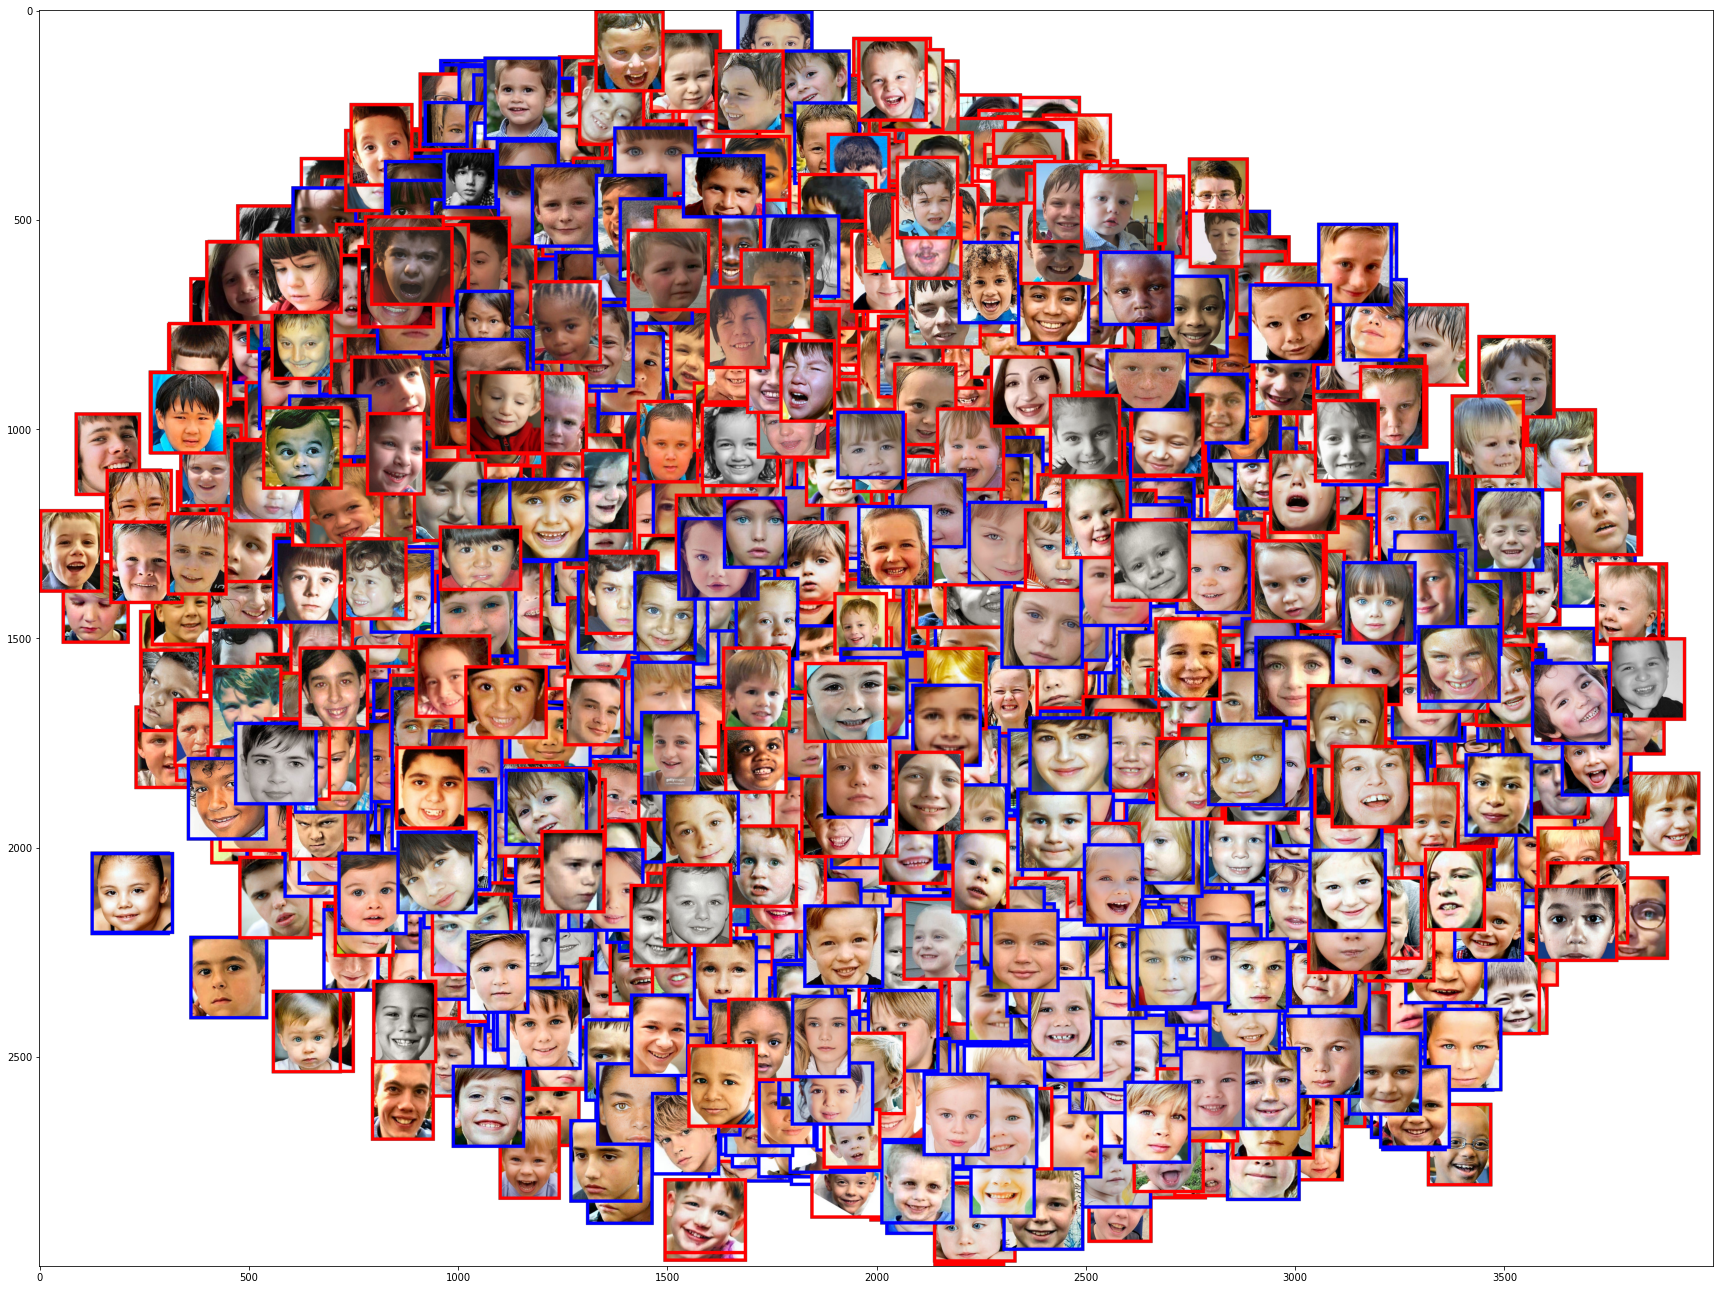

In [21]:
# Visualise class images in 2 dimesional space
visualise_tsne_images(tsne, train_imgs, labels)

In [22]:
# Shape of train images and labels
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


Get and pre-process validation data
- We have 100 images in the dataset named valid, these are entirely new - 50 images in each class
- We are using them as validation images to evaluate our model performance
- Get the validation images from the file path, shuffle them as val_imgs

In [23]:
# Repeat the above process for validation data to get val_images
val_autistic = "../input/autism-image-data/AutismDataset/valid/Autistic"
val_non_autistic = "../input/autism-image-data/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["../input/autism-image-data/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["../input/autism-image-data/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

17896

 - Read, resize and label the validation images
 - X_val - validation images, y_val - validation labels

In [24]:
# Get resized images and labels from validation data
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

23

Convert the resized images and labels into numpy array, visualising the class distribution for validation images

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation image labels')

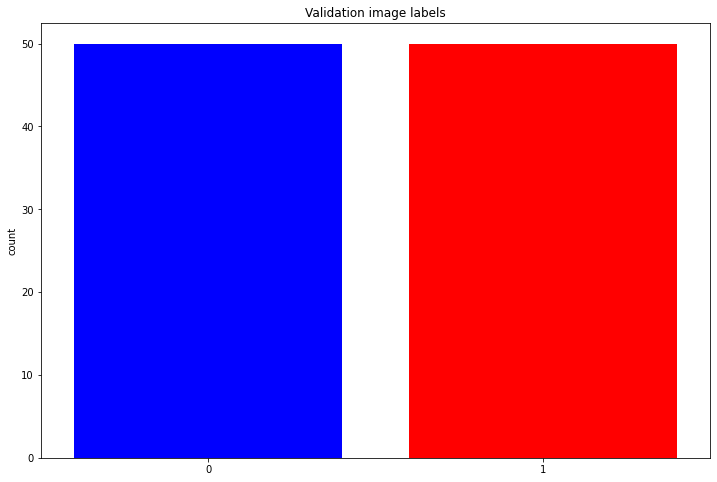

In [25]:
# Convert the lists to array
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [26]:
# Shape of validation images and labels
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [27]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
BATCH_SIZE = 32

***

## 5. Pre-trained model for Transfer Learning

- We use pre-trained Convolutional Neural Network(CNN) model VGG16 that has been trained on a large number of image data for image classification task

In [28]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

58900480/58889256 [==============================] - 0s 0us/step


In [30]:
# Freeze the layers in pre-trained model, we don't need to train again
for layer in base_model.layers:
   layer.trainable = False

In [31]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


***

## 6. Create custom model

Connecting the pre-trained CNN model to our custom fully connnected layer

In [32]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [33]:
# Create summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


 - Specify the loss function, optimizer and metrics for the model
 - 'binary-crossentropy' for loss since we are dealing with binary classification
 - Hyperparameter tuning is performed by choosing between optimizers and specifying learning rate to reduce loss

In [34]:
# Compile the model specifying optimizer, loss function and metrics
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])

 - Image data generator performs scaling of image pixel array between 0 and 1, also image transformation like zoom, flip are performed on the available train images to increase the training data for the model, so that model won't overfit by training on small dataset
 - We perform scaling on validation images but don't augument images in validation dataset
 - Validation images are used to test the performance of our model

In [35]:
# Configure data augumentation and scaling of images to prevent overfitting since we have a small train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

Image generator creates batches of train and validation data

In [36]:
# Create test and validation image generator
train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size = BATCH_SIZE)

***

## 7. Model training

 - Fit and train the model on the training data and measure the performance on unseen validation data
 - Specify number of epochs the model has to be trained on training data

In [37]:
# Tune the model based on the validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Train the model
history = model.fit(train_generator,
                              epochs=30,
                              validation_data=val_generator,
                              callbacks=[early_stopping],
                              workers=4,
                              use_multiprocessing=False
                             )

Epoch 1/30
80/80 [==============================] - 16s 88ms/step - loss: 0.7673 - acc: 0.6354 - val_loss: 0.5429 - val_acc: 0.7200
Epoch 2/30
80/80 [==============================] - 6s 77ms/step - loss: 0.5776 - acc: 0.6969 - val_loss: 0.5144 - val_acc: 0.7400
Epoch 3/30
80/80 [==============================] - 6s 77ms/step - loss: 0.5508 - acc: 0.7102 - val_loss: 0.5717 - val_acc: 0.6800
Epoch 4/30
80/80 [==============================] - 7s 83ms/step - loss: 0.5294 - acc: 0.7315 - val_loss: 0.5149 - val_acc: 0.7100
Epoch 5/30
80/80 [==============================] - 7s 78ms/step - loss: 0.5352 - acc: 0.7232 - val_loss: 0.5301 - val_acc: 0.7100


In [38]:
# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
history_df

loss       acc  val_loss  val_acc
0  0.767343  0.635433  0.542855     0.72
1  0.577592  0.696850  0.514435     0.74
2  0.550800  0.710236  0.571716     0.68
3  0.529402  0.731496  0.514921     0.71
4  0.535226  0.723228  0.530119     0.71

Let's see how well our model has learnt from the training data and how well it has performed on the unseen validation data 

Text(0.5, 1.0, 'Training and Validation Accuracy')

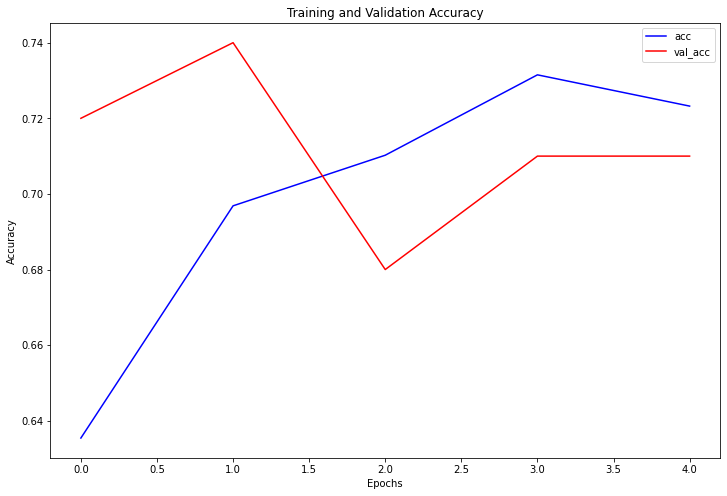

In [39]:
# Plot train and validation accuracy
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

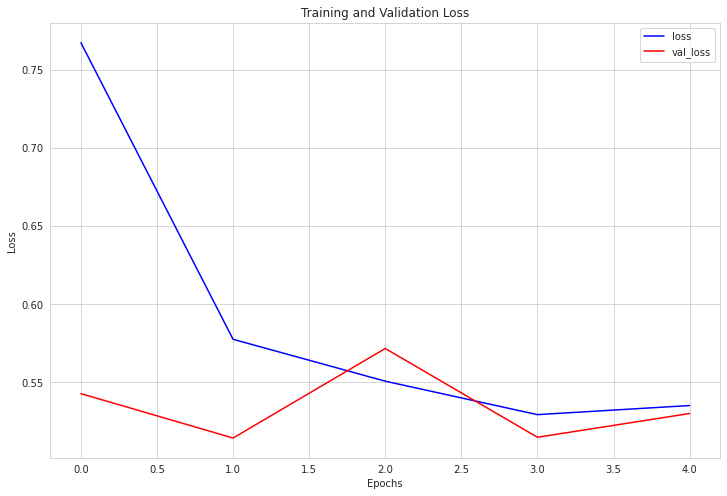

In [40]:
# Plot train and validation loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

- The learning curve of training loss shows a good trend and the loss minimises as the number of epochs increase
- The learning curve of validation loss shows noise around the training loss and the validation loss tends to increase after 15-17 epochs
- The validation accuracy fluctuates a lot too
- This may be because the model has very small data for validation compared to training

***

## 8. t-sne visualisation of NN feature vectors

Let's understand how our model see's the data
- Visualise the how our Neural network see's 
- To do this, extract output from the last dense layer before the classification layer - they are the feature vectors
- This can help us to see the anomalies/outliers in the data

In [41]:
# Function to get the features from the last hidden layer of neural network
def get_features(trained_model, validation_data):
    
    def get_truncated_model(trained_model):
    
        """Takes in the model, Returns truncated model without classification layer"""
        
        model = keras.models.Sequential()
        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation = 'relu'))
        
        for i, layer in enumerate(model.layers):
            layer.set_weights(trained_model.layers[i].get_weights())
            
        model.compile(optimizer = keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
        return model

    # Get truncated model
    truncated_model = get_truncated_model(model)
    
    # Use truncated model to predict features from the last hidden layer
    features = truncated_model.predict(validation_data)
        
    return features

In [42]:
# Get features of NN from the last hidden layer 
features = get_features(model, val_generator)

In [43]:
# Perform tsne on the features of the last hidden layer
tsne_model = TSNE(random_state=42, perplexity=4).fit_transform(features)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


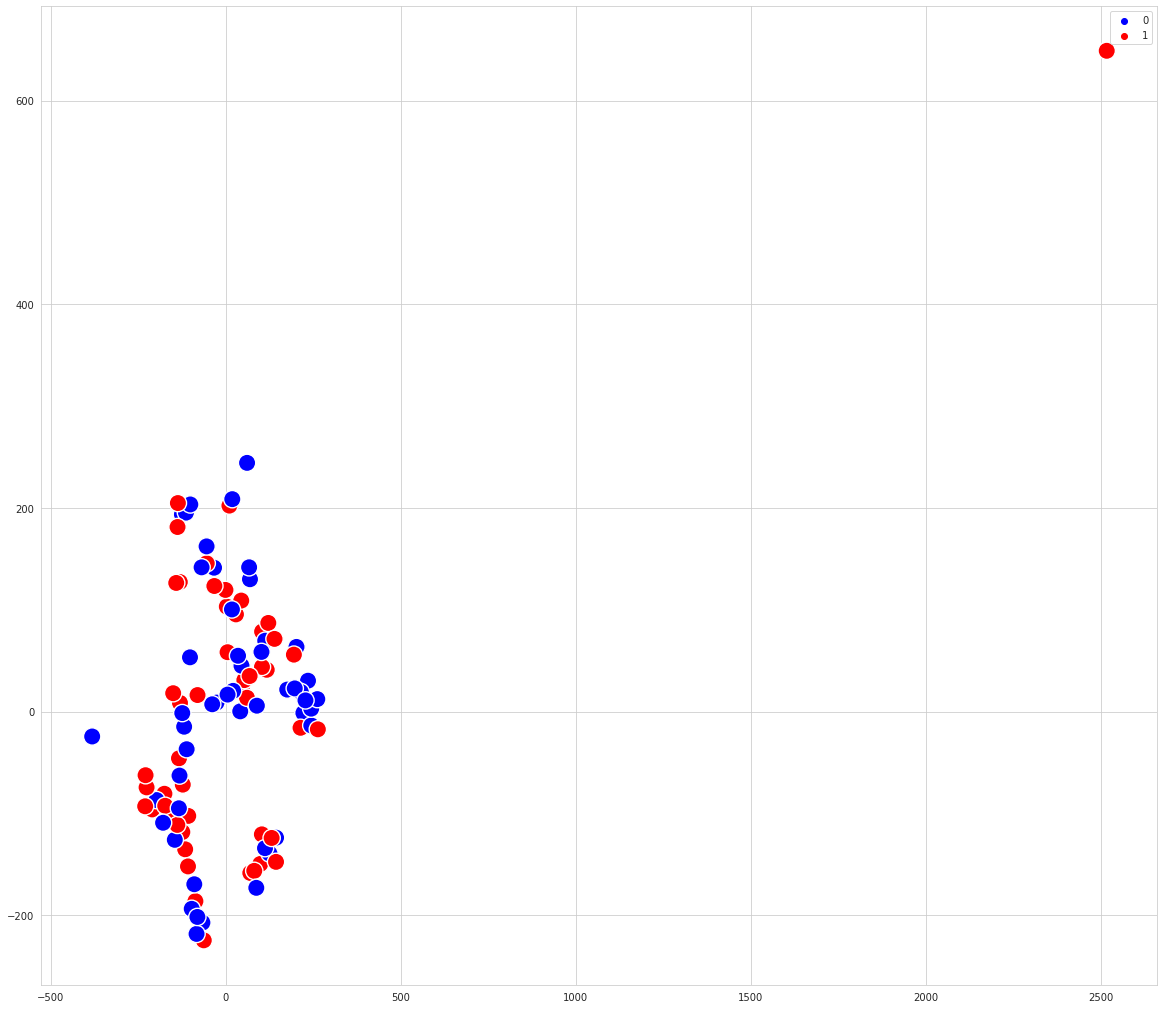

In [44]:
# Visualise the 2 dimensional projection of 512 dimensional features from the last hidden layer
visualise_tsne_datapoints(tsne_model, y_val)

- Our model tries to separate the data into small groups of own class, but there are some overlapping data points from other class in each cluster

In [45]:
# Function to plot 3D tsne data
def visualise_model_tsne_3d(tsne_model, val_labels):
    colour_map = [] 
    for i in val_labels: 
        if i == 1: 
            colour_map.append('r') 
        else: 
            colour_map.append('b')

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne_model), c=colour_map, s=50, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()

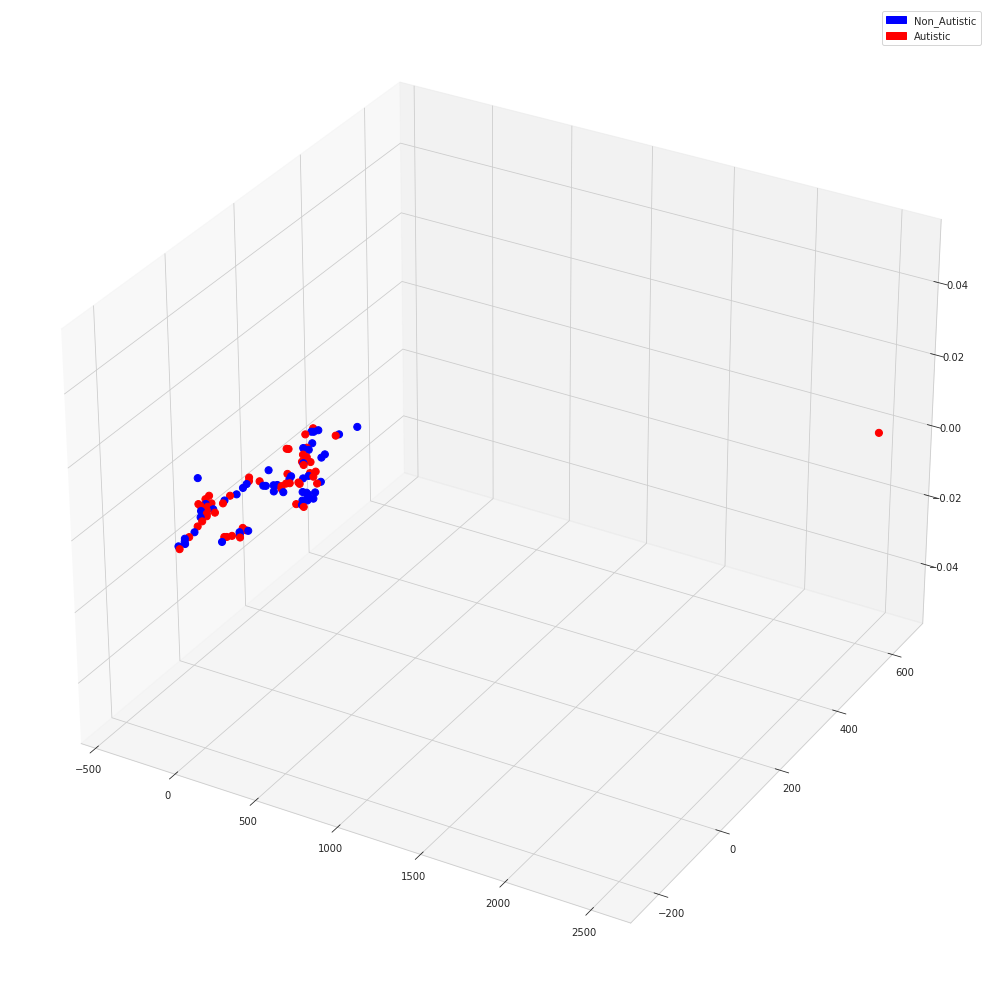

In [46]:
# Visualise the 3 dimensional projection of 512 dimensional features from the last hidden layer
visualise_model_tsne_3d(tsne_model, y_val)

- Let's visualise the same plot with each datapoint replaced with the corresponding image
- This gives us an idea of which images are wrongly classified in each group 

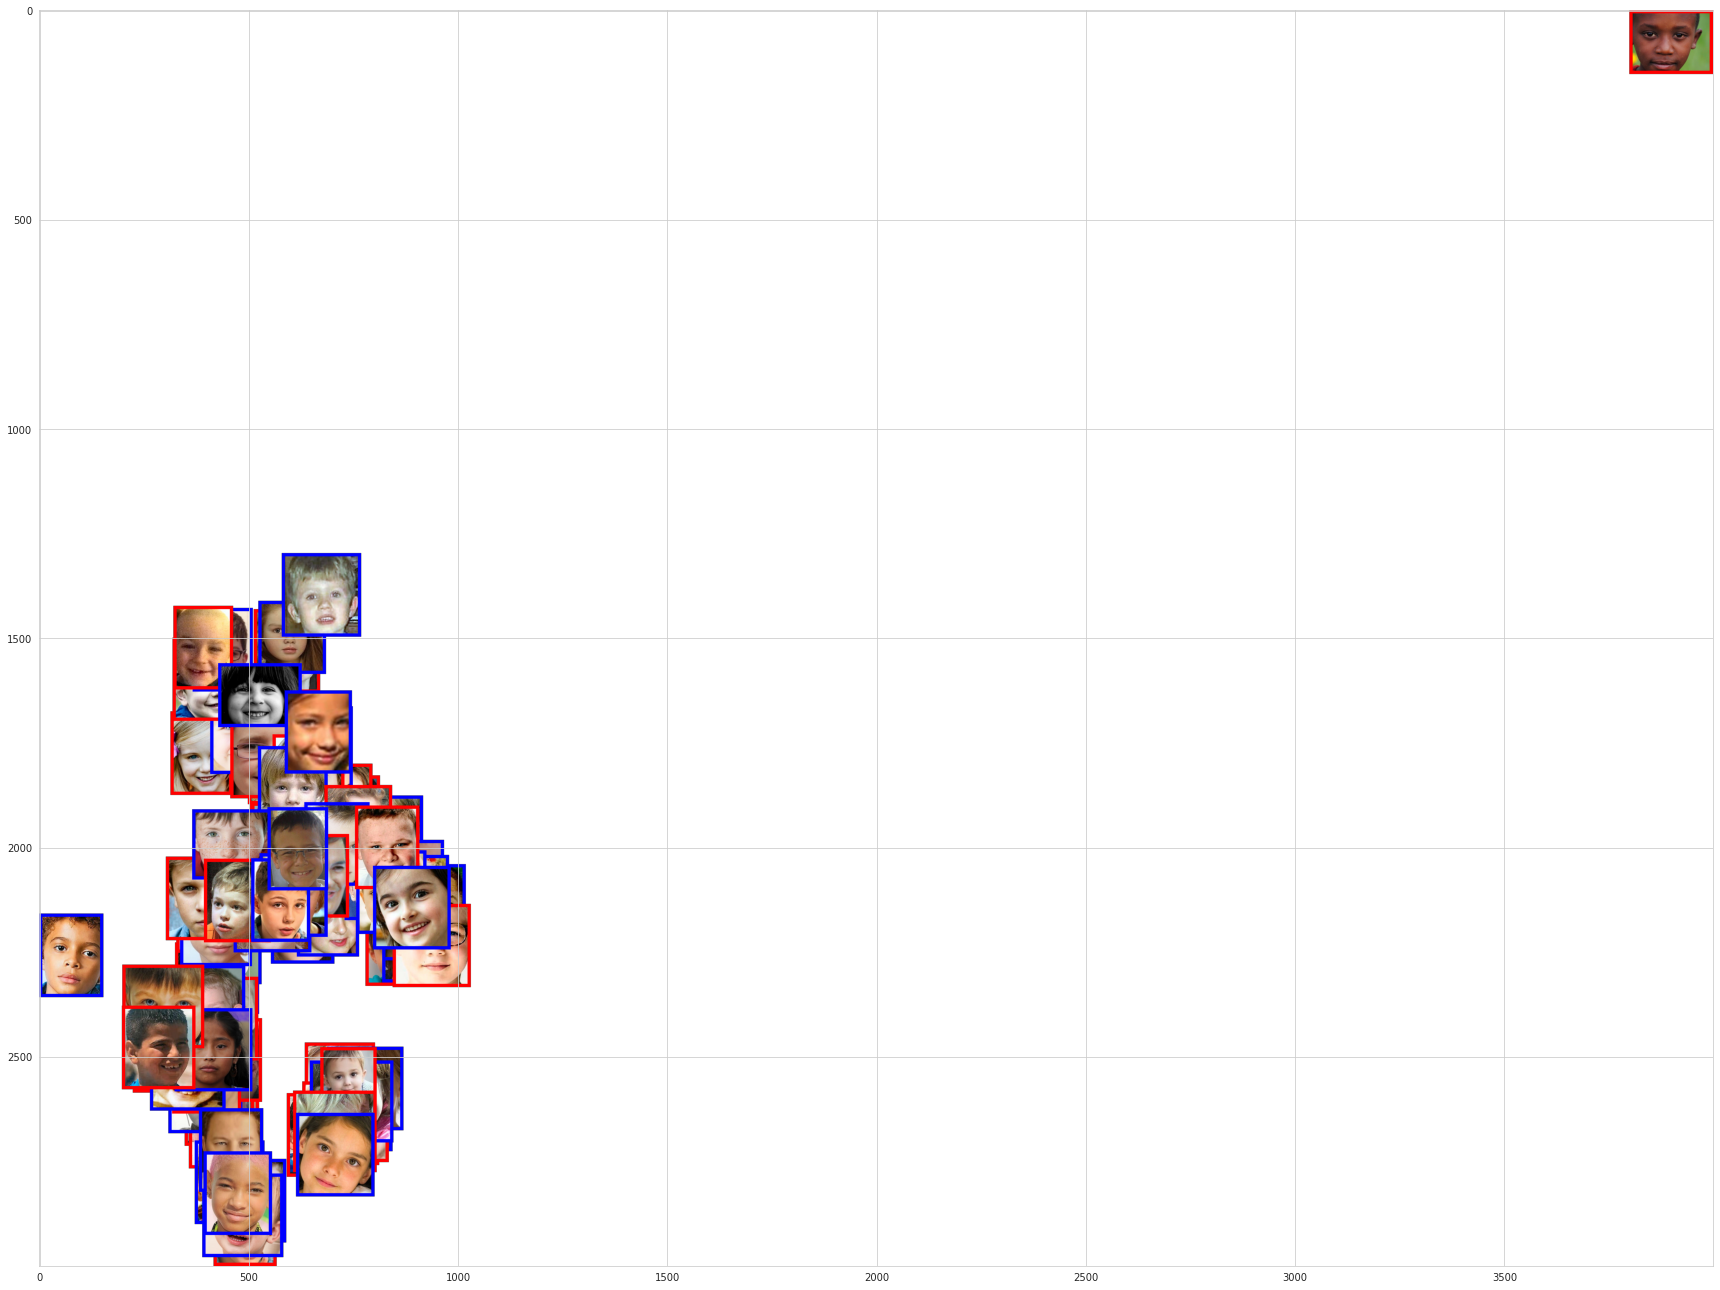

In [47]:
# Visualise the image grouping in the last hidden layer
visualise_tsne_images(tsne_model, train_imgs, y_val)

***

## 9. Test Data

Read and resize the test images, convert them into numpy array

In [48]:
# Read and resize test images
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


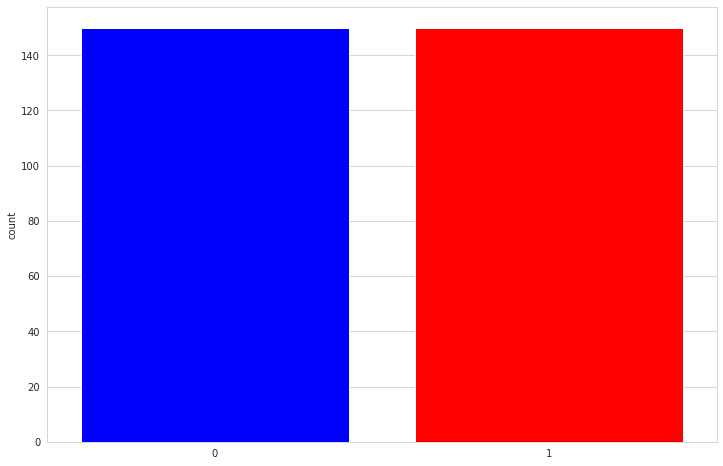

In [49]:
# Plotting the test label count in each class
sns.set_palette(sns.color_palette(["b", "r"]))
plt.figure(figsize=(12, 8))
sns.countplot(y_test, saturation=1);

***

## 10. Class Prediction

In [50]:
# Predict label for test images
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)

In [51]:
# Plot test images and their corresponding predictions
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

filename  test_labels  predictions
0         Autistic.92.jpg            1            1
1         Autistic.54.jpg            1            1
2         Autistic.80.jpg            1            1
3         Autistic.71.jpg            1            1
4     Non_Autistic.52.jpg            0            0
..                    ...          ...          ...
295       Autistic.30.jpg            1            0
296  Non_Autistic.103.jpg            0            0
297    Non_Autistic.5.jpg            0            0
298       Autistic.47.jpg            1            1
299   Non_Autistic.20.jpg            0            0

[300 rows x 3 columns]

In [52]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 73.00%


***

## 11. Model Validation

- We can evaluate the performance of the model on the test datset (since we konw the labels of the test data for this problem)
- We compare the metrics to select the best model
- For a well balanced dataset in both classes like in this dataset, Area Under the Curve of ROC can be used as evaluation metric to make comparison between models

- Classification report gives a summary of different metrics based on the predictive power of the model among positive and negative class
- If we are dealing with an unbalanced dataset (under most of real world circumstances), the accuracy alone is not a good metric for comparison
- Since models will be biased in predicitons for an unbalanced dataset, we rely on Precision, Recall metrics which take into account of Type 1 (False Positive FP) and Type 2 (False Negative FN) errors too

In [53]:
# Generating Classification report for model's performance in each class
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       150
           1       0.77      0.66      0.71       150

    accuracy                           0.73       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.73      0.73      0.73       300



Confusion Matrix gives the summary of True Positive(TP), True Negative(TN), False Positive(FP) and False Negative(FN) predictions

In [54]:
# Generating Confusion Matrix for the predictions against true labels
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[120,  30],
       [ 51,  99]])

Text(0.5, 1.0, 'Confusion Matrix')

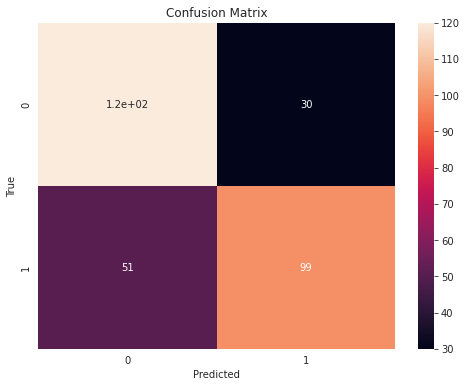

In [55]:
# Plotting the True Positives, True Negatives, False Positives and False Negatives from model's predictions
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

- The Receiver Operating Characteristic ROC curve shows the performance measure of the model in diagnosing both the classes
- Higher the Area under the Curve AUC, better the performance of the model


In [56]:
# Let's plot the AUC-ROC curve to assess the performance of our model
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc= auc(fpr, tpr)

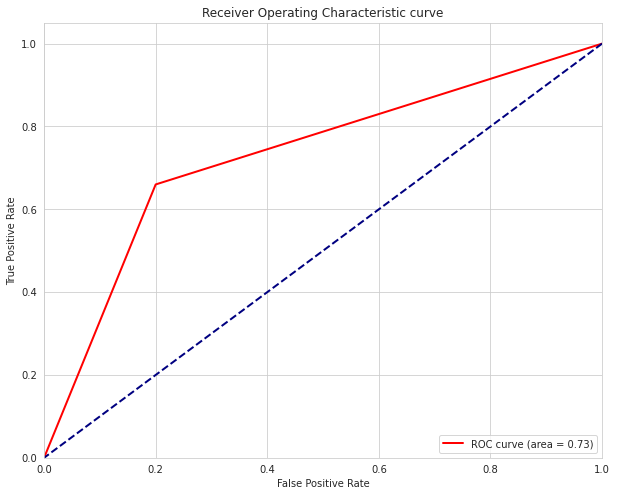

In [57]:
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1,0], [1,0], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = 'lower right')

***

Let's see how the model has predcited on a set of sample test images!

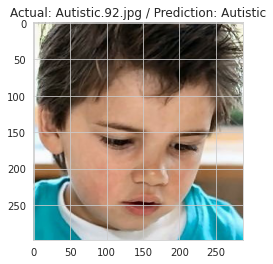

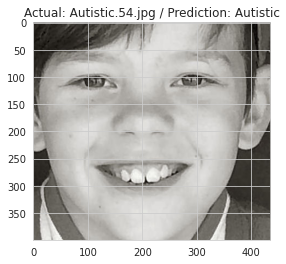

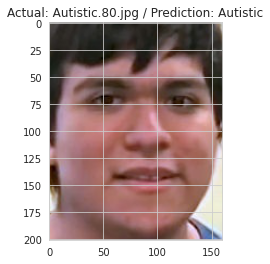

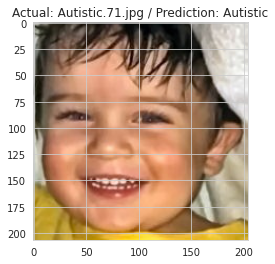

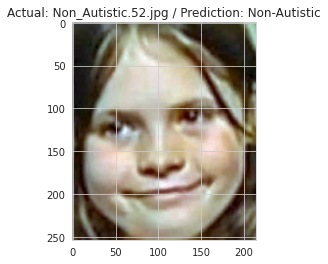

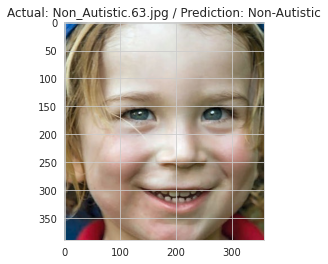

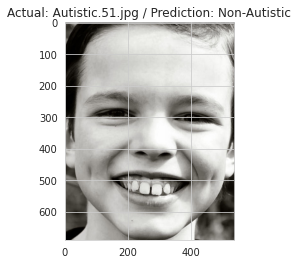

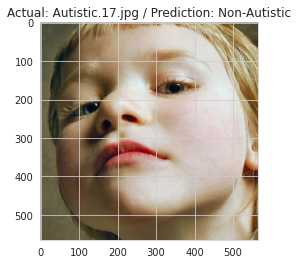

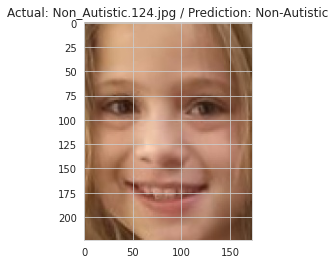

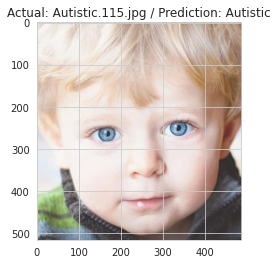

In [58]:
# Let's check our predcitions against some test images
plt.figure(figsize=(4,4))
for val, i in enumerate(test_imgs[:10]):
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.title('Actual: ' + os.path.basename(i) + ' / Prediction: ' +  f"{'Autistic' if predictions[val] == 1 else 'Non-Autistic'}")
    plt.show()

Our model has performed reasonably well for a small training data, we could still improvise the model for greater accuracy

***

## 12. Improvisations

- Providing the model with a large dataset for training can help the model to generalise on new data 
- Instead of using the small validation dataset (100 images), we can perform Cross Validation on the entire data to prevent overfitting
- We can perform fine tuning by training some of the top layers of pre-trained VGG16 model to customise the feature extraction

***

This notebook is inspired by [this article](https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9) that has detailed tutorial about image classification in neural networks<br>
Please upvote this notebook if you find it useful.

***